# Clean Simulation with powsybl for load flow simulations on an IEEE9 bus system
If you would like a more step by step walkthrough, look for the Load_flow_with_powsybl notebook


In [2]:
#importing the libraries
import pypowsybl as pp
import pypowsybl.loadflow as lf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os #to save files to path
from pypowsybl._pypowsybl import VoltageInitMode, BalanceType
SAVE_DIR = "Saved_results"
os.makedirs(SAVE_DIR, exist_ok=True)

In [3]:
#Creating the network
def create_ieee9_time_series_network(
        steps=5, 
        p_set_gen2=163, p_set_gen3=85,gen_max_p_factor=1.2,
        p_set_load5=90, p_set_load6=100, p_set_load8=125,
        q_set_load5=30, q_set_load6=35, q_set_load8=50,
        load_variation=0.1
        ):
    """
    Create IEEE 9-bus network and prepare time series variants with proper generator settings
    """
    # Create the IEEE 9-bus network
    network = pp.network.create_ieee9()
    
    # Get initial generator settings to preserve voltage setpoints
    initial_gens = network.get_generators()
    
    # Get Gen1's original target_p and set limits around it
    p_set_gen1 = initial_gens.loc['B1-G', 'target_p']
    
    # Update generators with complete settings
    network.update_generators(
        id=['B1-G'],
        target_p=[p_set_gen1],  # Keep original value
        min_p=[0.0],
        max_p=[p_set_gen1 * gen_max_p_factor],  # Allow 20% headroom
        voltage_regulator_on=[True],
        target_v=[initial_gens.loc['B1-G', 'target_v']]
    )
    
    network.update_generators(
        id=['B2-G'],
        target_p=[p_set_gen2],
        min_p=[0.0],
        max_p=[p_set_gen2 * gen_max_p_factor],
        voltage_regulator_on=[True],
        target_v=[initial_gens.loc['B2-G', 'target_v']]
    )
    
    network.update_generators(
        id=['B3-G'],
        target_p=[p_set_gen3],
        min_p=[0.0],
        max_p=[p_set_gen3 * gen_max_p_factor],
        voltage_regulator_on=[True],
        target_v=[initial_gens.loc['B3-G', 'target_v']]
    )
    # Define time steps
    snapshots = pd.date_range("2025-01-01 00:00", periods=steps, freq="h")
    
    # Define base loads and variation patterns
    base_loads = {
        'B5-L': {'p': p_set_load5, 'q': q_set_load5},
        'B6-L': {'p': p_set_load6, 'q': q_set_load6},
        'B8-L': {'p': p_set_load8, 'q': q_set_load8}
    }
    
    # Define oscillation patterns
    base_patterns = {
        'B5-L': np.array([1, 1, 1, -1, -1]),
        'B6-L': np.array([0, 1, 1, -1, -1]),
        'B8-L': np.array([0, 0, 1, 0, -1])
    }
    
    variation = load_variation  # 10% variation or per user input
    
    # Create variants for each time step
    for step in range(min(steps, 5)):
        variant_id = f"step_{step}"
        network.clone_variant("InitialState", variant_id)
        network.set_working_variant(variant_id)
        
        # Update loads based on patterns
        for load_id, base_load in base_loads.items():
            pattern_value = base_patterns[load_id][step]
            p_value = base_load['p'] * (1 + variation * pattern_value)
            q_value = base_load['q'] * (1 + variation * pattern_value)
            network.update_loads(id=load_id, p0=p_value, q0=q_value)
        
        network.set_working_variant("InitialState")
    
    return network, snapshots

# Returns a IEEE 9 bus network with default 5 timesteps, and default values for loads and generators

In [4]:
# Some helper functions to set parameters

def configure_slack_mode(network, mode='distributed', slack_bus_id=None, balance_method='P'):
    """
    Configure slack bus mode for load flow calculations with specific power balancing
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    mode : str
        'distributed' - distribute slack across generators
        'single' - use single slack bus
    slack_bus_id : str, optional
        ID of bus to use as slack when mode='single'
    balance_method : str
        'P_MAX' - distribute proportional to generator max power
        'P' - distribute proportional to current generator power
        'MARGIN' - distribute proportional to remaining generator margin
        'LOAD' - distribute on loads
    """
    # Map balance methods to enum values
    balance_types = {
        'P_MAX': BalanceType.PROPORTIONAL_TO_GENERATION_P_MAX,
        'P': BalanceType.PROPORTIONAL_TO_GENERATION_P,
        'MARGIN': BalanceType.PROPORTIONAL_TO_GENERATION_REMAINING_MARGIN,
        'LOAD': BalanceType.PROPORTIONAL_TO_LOAD
    }
    
    # Base parameters with explicit distribution settings
    params = pp.loadflow.Parameters(
        voltage_init_mode=VoltageInitMode.UNIFORM_VALUES,
        transformer_voltage_control_on=True,
        use_reactive_limits=True,
        write_slack_bus=True,
        distributed_slack=True if mode.lower() == 'distributed' else False,
        balance_type=balance_types[balance_method],
        read_slack_bus=False  # Don't read existing slack bus configuration
    )
    
    # Add provider-specific parameters for better control
    if mode.lower() == 'distributed':
        params.provider_parameters = {
            'slackBusSelectionMode': 'MOST_MESHED',
            'balanceType': balance_method,
            'distributedSlack': 'true',
            'loadPowerFactorConstant': 'false',  # Allow power factor to vary
            'remainingPowerAdjustment': 'true',   # Enable power adjustment
            'computeMaximumMismatch': 'true'
        }
    elif mode.lower() == 'single':
        params.provider_parameters = {
            'slackBusSelectionMode': 'NAME' if slack_bus_id else 'MOST_MESHED',
            'slackBusesIds': slack_bus_id if slack_bus_id else '',
            'distributedSlack': 'false'
        }
    
    return params
#returns a network with the specified slack mode and parameters
def set_line_current_limits(network, line_limits):
    """
    Set permanent current limits for lines using create_operational_limits
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    line_limits : dict
        Dictionary of line limits in format {line_id: current_limit_value}
        Example: {'L7-8': 500, 'L9-8': 400}
    
    Returns:
    --------
    Network
        Updated network with operational limits
    """
    # Prepare the arguments for create_operational_limits
    element_ids = list(line_limits.keys())
    values = list(line_limits.values())
    n_lines = len(element_ids)
    
    # Create operational limits with permanent current limits
    network.create_operational_limits(
        element_id=element_ids,
        side=['ONE'] * n_lines,  # 'ONE' for each line
        name=['PERMANENT'] * n_lines,
        type=['CURRENT'] * n_lines,
        value=values,
        acceptable_duration=[-1] * n_lines,  # -1 indicates permanent limit
        fictitious=[False] * n_lines
    )
    
    return network
# returns a network with the specified line current limits


In [5]:
#Two ways to run the loadflow, one with default (distributed) slack and one with configurable slack bus.

def run_time_series_loadflow(network, snapshots,print_debugging=False):
    """
    Run load flow for time series with distributed slack (default behavior)
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    snapshots : pd.DatetimeIndex
        Time points for simulation
    """
    # Initialize storage
    results = {}
    buses = network.get_buses()
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    
    # Initialize DataFrames
    bus_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )
    
    line_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            list(lines.index) + list(transformers.index),
            ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)', 'I1 (A)', 'I2 (A)']
        ])
    )
    
    slack_bus_results = pd.DataFrame(
        index=snapshots,
        columns=['bus_id', 'P_mismatch (MW)', 'distributed_P (MW)']
    )
    
    for step in range(len(snapshots)):
        if print_debugging: print(f"\n=== Processing timestep {step} ===")
        variant_id = f"step_{step}"
        network.set_working_variant(variant_id)
        
        # Get initial generator state
        initial_gens = network.get_generators()
        if print_debugging:
            print("\nInitial generator states:")
            for idx, gen in initial_gens.iterrows():
                print(f"{idx}: P={gen['p']:.2f}, target_P={gen['target_p']:.2f}, "
                    f"voltage_reg={gen['voltage_regulator_on']}")
            
        # Run load flow
        result = pp.loadflow.run_ac(network)
        results[step] = result
        
        # Get updated generator state
        final_gens = network.get_generators()
        if print_debugging:
            print("\nFinal generator states:")
            for idx, gen in final_gens.iterrows():
                print(f"{idx}: P={gen['p']:.2f}, target_P={gen['target_p']:.2f}, "
                    f"voltage_reg={gen['voltage_regulator_on']}")
            
        # Calculate total power change
        total_gen_change = sum(final_gens['p'] - initial_gens['p'])
        
        # Store component results with detailed power tracking
        component_result = result[0]
        if component_result.slack_bus_results:
            slack_info = component_result.slack_bus_results[0]
                        
            slack_bus_results.loc[snapshots[step]] = {
                'bus_id': slack_info.id,
                'P_mismatch (MW)': slack_info.active_power_mismatch,
                'distributed_P (MW)': component_result.distributed_active_power
            }
            
            if print_debugging:
                #For debugging, print the slack bus results
                print(f"\nPower Balance Analysis:")
                print(f"Slack bus: {slack_info.id}")
                print(f"Power mismatch: {slack_info.active_power_mismatch:.2f} MW")
                print(f"Distributed power: {component_result.distributed_active_power:.2f} MW")
                print(f"Total generator change: {total_gen_change:.2f} MW")
                print(f"Load flow status: {component_result.status}")
                
        
        # Store bus results
        for bus_id in buses.index:
            bus = buses.loc[bus_id]
            voltage_level = network.get_voltage_levels()[
                network.get_voltage_levels().index == bus['voltage_level_id']
            ].iloc[0]
            
            bus_results.loc[snapshots[step], (bus_id, 'V (pu)')] = bus['v_mag'] / voltage_level['nominal_v']
            bus_results.loc[snapshots[step], (bus_id, 'Angle (deg)')] = bus['v_angle']
        
        # Store line results
        updated_lines = network.get_lines()
        for line_id in lines.index:
            line = updated_lines.loc[line_id]
            line_results.loc[snapshots[step], (line_id, 'P0 (MW)')] = line['p1']
            line_results.loc[snapshots[step], (line_id, 'P1 (MW)')] = line['p2']
            line_results.loc[snapshots[step], (line_id, 'Q0 (MVAr)')] = line['q1']
            line_results.loc[snapshots[step], (line_id, 'Q1 (MVAr)')] = line['q2']
            line_results.loc[snapshots[step], (line_id, 'I1 (A)')] = line['i1']
            line_results.loc[snapshots[step], (line_id, 'I2 (A)')] = line['i2']
        
        # Store transformer results
        updated_transformers = network.get_2_windings_transformers()
        for trafo_id in transformers.index:
            trafo = updated_transformers.loc[trafo_id]
            line_results.loc[snapshots[step], (trafo_id, 'P0 (MW)')] = trafo['p1']
            line_results.loc[snapshots[step], (trafo_id, 'P1 (MW)')] = trafo['p2']
            line_results.loc[snapshots[step], (trafo_id, 'Q0 (MVAr)')] = trafo['q1']
            line_results.loc[snapshots[step], (trafo_id, 'Q1 (MVAr)')] = trafo['q2']
        network.set_working_variant("InitialState")
    
    return results, bus_results, line_results, slack_bus_results

def run_time_series_loadflow_with_slack_modification(network, snapshots, slack_mode='distributed', 
                           slack_bus_id=None, balance_method='P',print_debugging=False):
    """
    Run load flow for time series with configurable slack handling
        
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    snapshots : pd.DatetimeIndex
        Time points for simulation
    slack_mode : str
        'distributed' or 'single'
    slack_bus_id : str, optional
        ID of slack bus if using single mode
    """
        # Initialize storage
    results = {}
    buses = network.get_buses()
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    
    # Initialize DataFrames
    bus_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )
    
    line_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            list(lines.index) + list(transformers.index),
            ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)', 'I1 (A)', 'I2 (A)']
        ])
    )
    
    # Add branch flow tracking
    slack_bus_results = pd.DataFrame(
        index=snapshots,
        columns=['bus_id', 'P_mismatch (MW)', 'distributed_P (MW)', 'P_branch_sum (MW)']
    )
    
    for step in range(len(snapshots)):
        if print_debugging:print(f"\nProcessing timestep {step}")
        variant_id = f"step_{step}"
        network.set_working_variant(variant_id)
        
        # Store initial branch flows
        initial_lines = network.get_lines()
        
        # Run load flow
        lf_params = configure_slack_mode(network, slack_mode, slack_bus_id, balance_method)
        result = pp.loadflow.run_ac(network, parameters=lf_params)
        
        # Get updated branch flows
        updated_lines = network.get_lines()
        updated_transformers = network.get_2_windings_transformers()
        
        # Calculate net power flow at each bus through branches
        bus_branch_flows = {}
        for bus_id in buses.index:
            net_power = 0.0
            
            # Add line contributions
            for _, line in updated_lines.iterrows():
                if line['bus1_id'] == bus_id:
                    net_power += line['p1']  # Power leaving bus
                elif line['bus2_id'] == bus_id:
                    net_power += line['p2']  # Power entering bus
            
            # Add transformer contributions
            for _, trafo in updated_transformers.iterrows():
                if trafo['bus1_id'] == bus_id:
                    net_power += trafo['p1']
                elif trafo['bus2_id'] == bus_id:
                    net_power += trafo['p2']
            
            bus_branch_flows[bus_id] = net_power
        
        # Store component results
        if result[0].slack_bus_results:
            slack_info = result[0].slack_bus_results[0]
            slack_bus_id = slack_info.id
            
            # Calculate total branch power flow at slack bus
            slack_power_flow = bus_branch_flows.get(slack_bus_id, 0.0)
            
            slack_bus_results.loc[snapshots[step]] = {
                'bus_id': slack_bus_id,
                'P_mismatch (MW)': slack_info.active_power_mismatch,
                'distributed_P (MW)': result[0].distributed_active_power,
                'P_branch_sum (MW)': slack_power_flow
            }
            if print_debugging:
                print(f"\nPower balance at step {step}:")
                print(f"Slack bus: {slack_bus_id}")
                print(f"Power mismatch: {slack_info.active_power_mismatch:.2f} MW")
                print(f"Branch power sum at slack: {slack_power_flow:.2f} MW")
                
                # Print branch flows connected to slack bus
                print("\nBranch flows connected to slack bus:")
                for _, line in updated_lines.iterrows():
                    if slack_bus_id in [line['bus1_id'], line['bus2_id']]:
                        print(f"Line {line.name}: P1={line['p1']:.2f} MW, P2={line['p2']:.2f} MW")
            
        # Store component and slack results
        component_result = result[0]
        if component_result.slack_bus_results:
            slack_info = component_result.slack_bus_results[0]
            
            # Calculate total power adjustment across all generators
            generators = network.get_generators()
            total_p_adjustment = 0
            
            if slack_mode.lower() == 'distributed':
                # Sum up changes in generator outputs
                for _, gen in generators.iterrows():
                    if gen['voltage_regulator_on']:
                        total_p_adjustment += (gen['p'] - gen['target_p'])
            
            slack_bus_results.loc[snapshots[step]] = {
                'bus_id': slack_info.id,
                'P_mismatch (MW)': slack_info.active_power_mismatch,
                'distributed_P (MW)': component_result.distributed_active_power,
                'total_P_adjustment (MW)': total_p_adjustment
            }
            if print_debugging:    
                print(f"\nSnapshot {step} power balance:")
                print(f"Mismatch: {slack_info.active_power_mismatch:.2f} MW")
                print(f"Distributed: {component_result.distributed_active_power:.2f} MW")
                print(f"Total adjustment: {total_p_adjustment:.2f} MW")
            
        # Get updated network data for this variant
        updated_buses = network.get_buses()
        updated_lines = network.get_lines()
        updated_transformers = network.get_2_windings_transformers()
        generators = network.get_generators()
        loads = network.get_loads()
        voltage_levels = network.get_voltage_levels()
        
        # Store bus results
        for _, bus in updated_buses.iterrows():
            try:
                bus_id = bus.name
                voltage_level_id = bus['voltage_level_id']
                voltage_level = voltage_levels[voltage_levels.index == voltage_level_id].iloc[0]
                nominal_v = voltage_level['nominal_v']
                
                # Debug voltage values
                #print(f"\nBus {bus_id} voltage details:")
                #print(f"Voltage Level ID: {voltage_level_id}")
                #print(f"Nominal V: {nominal_v}")
                #print(f"V_mag: {bus['v_mag']}")
                #print(f"V_angle: {bus['v_angle']}")
                #print(f"V (pu): {bus['v_mag'] / nominal_v}")
                
                # Initialize power totals for this bus
                p_total = 0.0
                q_total = 0.0
                
                # Add generator injections
                bus_gens = generators[generators['bus_id'] == bus_id]
                for _, gen in bus_gens.iterrows():
                    # For generators, use actual values after load flow
                    p_total += gen['p']
                    q_total += gen['q']
                    if print_debugging:print(f"Generator {gen.name} actual P={gen['p']}, Q={gen['q']}")
                
                # Subtract load consumption
                bus_loads = loads[loads['bus_id'] == bus_id]
                for _, load in bus_loads.iterrows():
                    p_total -= load['p0']
                    q_total -= load['q0']
                    if print_debugging: print(f"Load {load.name} P=-{load['p0']}, Q=-{load['q0']}")
                
                # Store results for this timestep
                bus_results.loc[snapshots[step], (bus_id, 'P (MW)')] = p_total
                bus_results.loc[snapshots[step], (bus_id, 'Q (MVAr)')] = q_total
                bus_results.loc[snapshots[step], (bus_id, 'V (pu)')] = bus['v_mag'] / nominal_v
                bus_results.loc[snapshots[step], (bus_id, 'Angle (deg)')] = bus['v_angle']
                
            except Exception as e:
                print(f"Error processing bus {bus_id}: {str(e)}")
        
        # Store line results
        for _, line in updated_lines.iterrows():
            try:
                line_id = line.name
                line_results.loc[snapshots[step], (line_id, 'P0 (MW)')] = line['p1']
                line_results.loc[snapshots[step], (line_id, 'P1 (MW)')] = line['p2']
                line_results.loc[snapshots[step], (line_id, 'Q0 (MVAr)')] = line['q1']
                line_results.loc[snapshots[step], (line_id, 'Q1 (MVAr)')] = line['q2']
                line_results.loc[snapshots[step], (line_id, 'I1 (A)')] = line['i1']
                line_results.loc[snapshots[step], (line_id, 'I2 (A)')] = line['i2']
            except Exception as e:
                print(f"Error processing line {line_id}: {str(e)}")
        
        # Store transformer results
        updated_transformers = network.get_2_windings_transformers()
        for trafo_id in transformers.index:
            trafo = updated_transformers.loc[trafo_id]
            line_results.loc[snapshots[step], (trafo_id, 'P0 (MW)')] = trafo['p1']
            line_results.loc[snapshots[step], (trafo_id, 'P1 (MW)')] = trafo['p2']
            line_results.loc[snapshots[step], (trafo_id, 'Q0 (MVAr)')] = trafo['q1']
            line_results.loc[snapshots[step], (trafo_id, 'Q1 (MVAr)')] = trafo['q2']
        # Reset to base variant
        network.set_working_variant("InitialState")
    
    return results, bus_results, line_results, slack_bus_results

In [6]:
#Visualization and result summary functions
def plot_network_results(network, results_df, slack_results):
    """
    Plot network results in 4 subplots: P, Q, V_mag, and V_ang with bus types in legend
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    results_df : pd.DataFrame
        DataFrame containing bus results
    slack_results : pd.DataFrame
        DataFrame containing slack bus results
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    # Get data for each bus
    buses = network.get_buses()
    loads = network.get_loads()
    generators = network.get_generators()
    
    # Get slack bus ID from results
    slack_bus_id = slack_results['bus_id'].iloc[0]
    
    for bus_id in buses.index:
        # Determine bus type for legend
        if bus_id in loads['bus_id'].values:
            bus_type = f"{bus_id} (Load)"
        elif bus_id in generators['bus_id'].values:
            gen = generators[generators['bus_id'] == bus_id]
            if bus_id == slack_bus_id:
                bus_type = f"{bus_id} (Gen-Slack)"
                # Add distributed power to slack bus P
                results_df.loc[:, (bus_id, 'P (MW)')] += slack_results['distributed_P (MW)']
            else:
                if gen['voltage_regulator_on'].iloc[0]:
                    bus_type = f"{bus_id} (Gen-PV)"
                else:
                    bus_type = f"{bus_id} (Gen-PQ)"
        else:
            bus_type = bus_id
            
        # Active Power (P)
        ax1.plot(results_df.index, results_df[bus_id]['P (MW)'], marker='o', label=bus_type)
        ax1.set_ylabel('P (MW)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True)
        
        # Reactive Power (Q)
        ax2.plot(results_df.index, results_df[bus_id]['Q (MVAr)'], marker='o', label=bus_type)
        ax2.set_ylabel('Q (MVAr)')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True)
        
        # Voltage Magnitude
        ax3.plot(results_df.index, results_df[bus_id]['V (pu)'], marker='o', label=bus_type)
        ax3.set_ylabel('Voltage (p.u.)')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True)
        
        # Voltage Angle
        ax4.plot(results_df.index, results_df[bus_id]['Angle (deg)'], marker='o', label=bus_type)
        ax4.set_ylabel('Angle (degrees)')
        ax4.set_xlabel('Time')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax4.grid(True)

    # Add titles with additional information
    ax1.set_title('Active Power at Buses\n' + 
                 f'Slack Bus Power Mismatch: {slack_results["P_mismatch (MW)"].iloc[-1]:.2f} MW')
    
    plt.tight_layout()
    plt.show()

def plot_line_results(network, results_df):
    """
    Plot line and transformer flow results
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    results_df : pd.DataFrame
        DataFrame containing line and transformer results with MultiIndex columns
    """
    # Get all branches and current limits
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    all_branches = list(lines.index) + list(transformers.index)
    
    # Get current limits DataFrame
    current_limits_df = network.get_current_limits()
    
    for i, branch_id in enumerate(all_branches):
        # Determine if branch is a line or transformer
        is_line = branch_id in lines.index
        
        try:
            # Create figure with appropriate number of subplots
            n_plots = 3 if is_line else 2
            fig, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 4))
            
            # Make axs array-like if only one subplot
            if n_plots == 1:
                axs = [axs]
            
            # Get branch details
            if is_line:
                branch = lines.loc[branch_id]
                try:
                    current_limit = current_limits_df.loc[(branch_id, 'permanent_limit'), 'value']
                except:
                    current_limit = None
            else:
                branch = transformers.loc[branch_id]
                current_limit = None
            
            from_bus = branch['bus1_id']
            to_bus = branch['bus2_id']
            branch_name = f"{branch_id} ({from_bus}->{to_bus})"
            
            # Get column names for this branch
            branch_cols = [col for col in results_df.columns if col[0] == branch_id]
            
            if not branch_cols:
                print(f"No data found for branch {branch_id}")
                continue
                
            # Active Power (P) plot
            try:
                p0_series = results_df.loc[:, (branch_id, 'P0 (MW)')]
                p1_series = results_df.loc[:, (branch_id, 'P1 (MW)')]
                axs[0].plot(results_df.index, p0_series, marker='o',
                           label=f"P-in (from {from_bus})")
                axs[0].plot(results_df.index, -p1_series, marker='s',
                           label=f"P-out (to {to_bus})")
                axs[0].set_ylabel('P (MW)')
                axs[0].set_title(f"Active Power Flow - {branch_name}")
                axs[0].legend()
                axs[0].grid(True)
            except Exception as e:
                print(f"Error plotting active power for {branch_id}: {e}")
            
            # Reactive Power (Q) plot
            try:
                q0_series = results_df.loc[:, (branch_id, 'Q0 (MVAr)')]
                q1_series = results_df.loc[:, (branch_id, 'Q1 (MVAr)')]
                axs[1].plot(results_df.index, q0_series, marker='o',
                           label=f"Q-in (from {from_bus})")
                axs[1].plot(results_df.index, -q1_series, marker='s',
                           label=f"Q-out (to {to_bus})")
                axs[1].set_ylabel('Q (MVAr)')
                axs[1].set_title(f"Reactive Power Flow - {branch_name}")
                axs[1].legend()
                axs[1].grid(True)
            except Exception as e:
                print(f"Error plotting reactive power for {branch_id}: {e}")
            
            # Current (I) plot - only for lines
            if is_line:
                try:
                    i1_series = results_df.loc[:, (branch_id, 'I1 (A)')]
                    i2_series = results_df.loc[:, (branch_id, 'I2 (A)')]
                    
                    axs[2].plot(results_df.index, i1_series, marker='o',
                               label=f"I-in (from {from_bus})")
                    axs[2].plot(results_df.index, i2_series, marker='s',
                               label=f"I-out (to {to_bus})")
                    
                    if current_limit is not None:
                        axs[2].axhline(y=current_limit, color='r', linestyle='--',
                                     label=f"Current Limit ({current_limit:.0f} A)")
                        max_loading = max(max(i1_series), max(i2_series)) / current_limit * 100
                        axs[2].text(0.02, 0.98, f'Max Loading: {max_loading:.1f}%',
                                  transform=axs[2].transAxes, verticalalignment='top')
                    
                    axs[2].set_ylabel('Current (A)')
                    axs[2].set_title(f"Current Flow - {branch_name}")
                    axs[2].legend()
                    axs[2].grid(True)
                except Exception as e:
                    print(f"Error plotting current for {branch_id}: {e}")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing branch {branch_id}: {e}")
            continue

def create_results_summary(network, results, bus_results, line_results, slack_results, snapshots):
    """
    Create a comprehensive summary of simulation results and network parameters
    using efficient DataFrame operations
    """
    # Create separate DataFrames for each type of data
    time_series_data = {}
    
    # Add slack bus results
    for col in slack_results.columns:
        time_series_data[f'Slack_{col}'] = slack_results[col]
    
    # Add bus results
    for bus_id in network.get_buses().index:
        for metric in ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']:
            time_series_data[f'Bus_{bus_id}_{metric}'] = bus_results[bus_id][metric]
    
    # Add line results
    for line_id in network.get_lines().index:
        for metric in ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)', 'I1 (A)', 'I2 (A)']:
            time_series_data[f'Line_{line_id}_{metric}'] = line_results[line_id][metric]
    
    # Add transformer results
    for trafo_id in network.get_2_windings_transformers().index:
        for metric in ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)']:
            time_series_data[f'Trafo_{trafo_id}_{metric}'] = line_results[trafo_id][metric]
    
    # Create time series DataFrame
    summary_df = pd.DataFrame(time_series_data, index=snapshots)
    
    # Create network parameters dictionary
    network_params = {}
    
    # Add line parameters
    lines = network.get_lines()
    for line_id, line in lines.iterrows():
        params = {
            f'Line_{line_id}_r': line['r'],
            f'Line_{line_id}_x': line['x'],
            f'Line_{line_id}_g1': line['g1'],
            f'Line_{line_id}_b1': line['b1'],
            f'Line_{line_id}_g2': line['g2'],
            f'Line_{line_id}_b2': line['b2']
        }
        network_params.update(params)
    
    # Add transformer parameters
    trafos = network.get_2_windings_transformers()
    for trafo_id, trafo in trafos.iterrows():
        params = {
            f'Trafo_{trafo_id}_r': trafo['r'],
            f'Trafo_{trafo_id}_x': trafo['x'],
            f'Trafo_{trafo_id}_rated_u1': trafo['rated_u1'],
            f'Trafo_{trafo_id}_rated_u2': trafo['rated_u2'],
            f'Trafo_{trafo_id}_rated_s': trafo['rated_s']
        }
        network_params.update(params)
    
    # Add generator parameters
    gens = network.get_generators()
    for gen_id, gen in gens.iterrows():
        params = {
            f'Gen_{gen_id}_target_p': gen['target_p'],
            f'Gen_{gen_id}_min_p': gen['min_p'],
            f'Gen_{gen_id}_max_p': gen['max_p'],
            f'Gen_{gen_id}_target_v': gen['target_v'],
            f'Gen_{gen_id}_voltage_regulator_on': gen['voltage_regulator_on']
        }
        network_params.update(params)
    
    # Add load parameters
    loads = network.get_loads()
    for load_id, load in loads.iterrows():
        params = {
            f'Load_{load_id}_p0': load['p0'],
            f'Load_{load_id}_q0': load['q0']
        }
        network_params.update(params)
    
    # Create parameters DataFrame with same index as summary_df
    params_df = pd.DataFrame(
        {f'Param_{k}': [v] * len(snapshots) for k, v in network_params.items()},
        index=snapshots
    )
    
    # Combine time series and parameters using concat
    final_df = pd.concat([summary_df, params_df], axis=1)
    
    return final_df

In [7]:
def run_power_system_analysis(
        steps=5,
        p_set_gen2=163, p_set_gen3=85,
        p_set_load5=90, p_set_load6=100, p_set_load8=125,
        q_set_load5=30, q_set_load6=35, q_set_load8=50,
        load_variation=0.1,
        line_limits=None,
        use_configured_slack=False,
        slack_bus_id=None,
        balance_method='P_MAX',  
        save_results=False,
        show_plots=True
    ):
    """
    Comprehensive wrapper for power system analysis
    
    Parameters:
    -----------
    ... [other parameters remain the same] ...
    balance_method : str
        Method for distributing power in distributed slack mode:
        'P_MAX' - proportional to generator max power
        'P' - proportional to current generator power
        'MARGIN' - proportional to remaining generator margin
        'LOAD' - distribute on loads
    """
    
    # Create network and run time series
    network, snapshots = create_ieee9_time_series_network(
        steps=steps,
        p_set_gen2=p_set_gen2, p_set_gen3=p_set_gen3,
        p_set_load5=p_set_load5, p_set_load6=p_set_load6, p_set_load8=p_set_load8,
        q_set_load5=q_set_load5, q_set_load6=q_set_load6, q_set_load8=q_set_load8,
        load_variation=load_variation
    )
    
    if line_limits is not None:
        network = set_line_current_limits(network, line_limits)
    
    # Run load flow with appropriate configuration
    if use_configured_slack:
        if slack_bus_id:
            # Single slack bus mode
            results, bus_results, line_results, slack_results = run_time_series_loadflow_with_slack_modification(
                network, snapshots, 
                slack_mode='single', 
                slack_bus_id=slack_bus_id
            )
        else:
            # Distributed slack with specified balance method
            results, bus_results, line_results, slack_results = run_time_series_loadflow_with_slack_modification(
                network, snapshots,
                slack_mode='distributed',
                balance_method=balance_method
            )
    else:
        # Default distributed slack
        results, bus_results, line_results, slack_results = run_time_series_loadflow(
            network, snapshots
        )

    
    # Create results summary
    results_summary = create_results_summary(
        network, results, bus_results, line_results, slack_results, snapshots)
    
    # Save results if requested
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        os.makedirs(SAVE_DIR, exist_ok=True)
        
        # Save each DataFrame as a separate CSV file
        results_summary.to_csv(os.path.join(SAVE_DIR, f'all_results_{timestamp}.csv'))
        slack_results.to_csv(os.path.join(SAVE_DIR, f'slack_results_{timestamp}.csv'))
        bus_results.to_csv(os.path.join(SAVE_DIR, f'bus_results_{timestamp}.csv'))
        line_results.to_csv(os.path.join(SAVE_DIR, f'line_results_{timestamp}.csv'))
        
        print(f"Results saved to {SAVE_DIR} with timestamp {timestamp}")
    
    # Generate plots if requested
    if show_plots:
        plot_network_results(network, bus_results, slack_results)
        plot_line_results(network, line_results)
    
    # Return all results in a dictionary
    return {
        'network': network,
        'results': results,
        'bus_results': bus_results,
        'line_results': line_results,
        'slack_results': slack_results,
        'summary': results_summary,
        'snapshots': snapshots
    }

## Ways to use the simulation

In [15]:
# Run with distributed slack using generator current power
results_p = run_power_system_analysis(
    steps=5,
    use_configured_slack=True,
    balance_method='P',
    #save_results=True,# if you want to save as csv
    show_plots=False
)

In [8]:
# Run with distributed slack using generator margins
results_margin = run_power_system_analysis(
    steps=5,
    use_configured_slack=True,
    balance_method='MARGIN',
    #save_results=True,# if you want to save as csv
    show_plots=False
)

In [9]:
# Run with distributed slack on loads
results_load = run_power_system_analysis(
    steps=5,
    use_configured_slack=True,
    balance_method='LOAD',
    #save_results=True,# if you want to save as csv
    show_plots=False
)

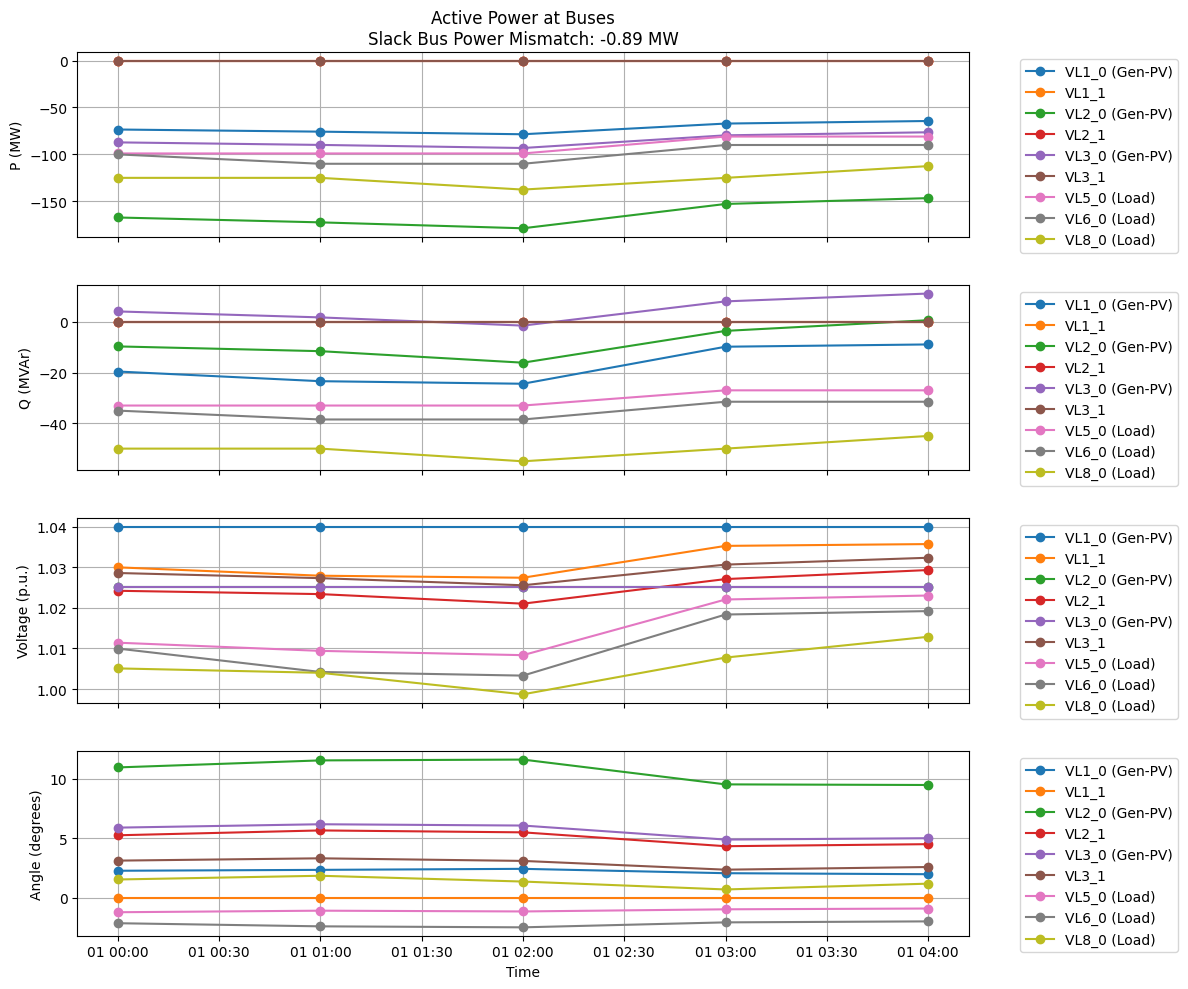

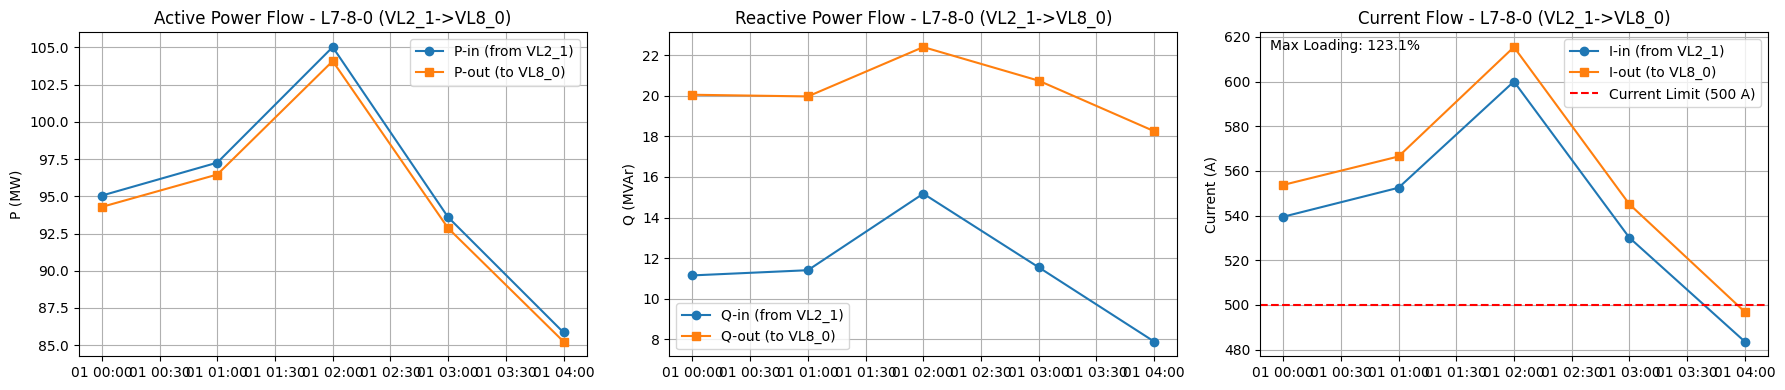

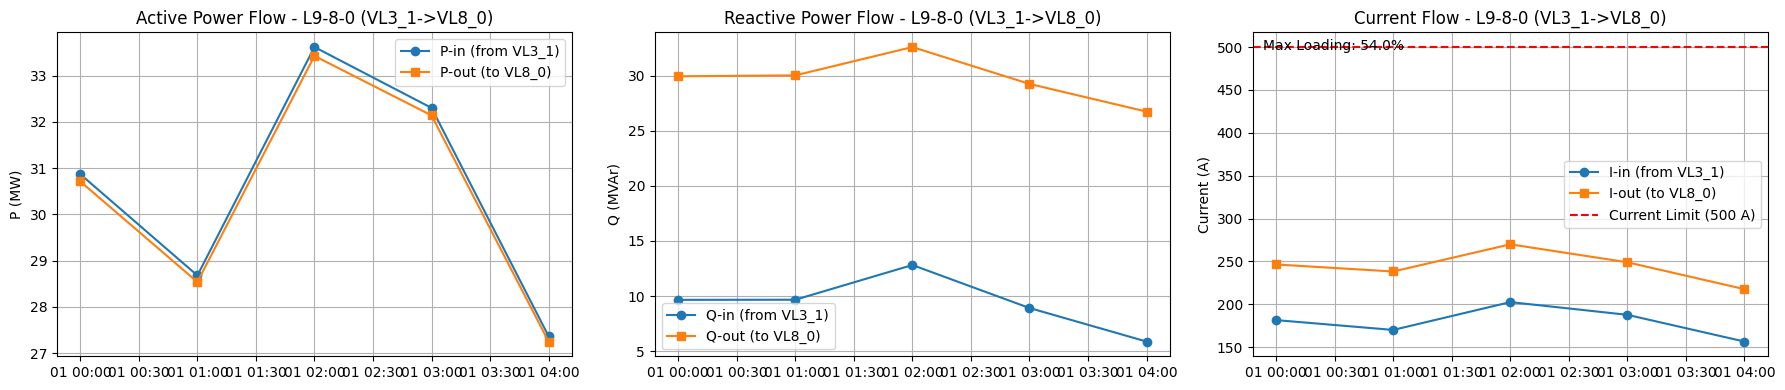

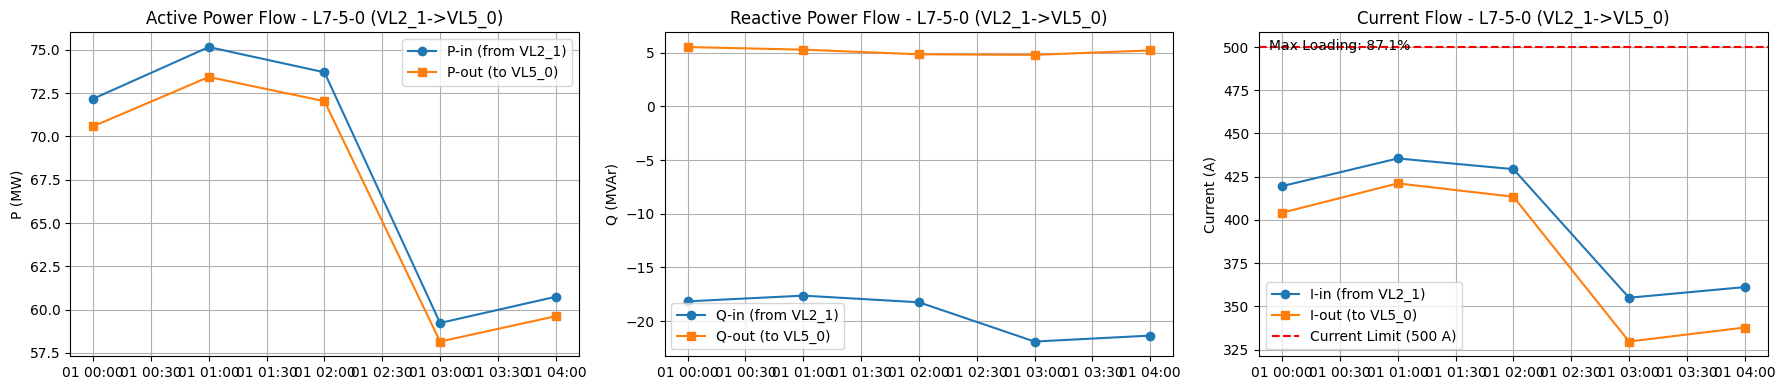

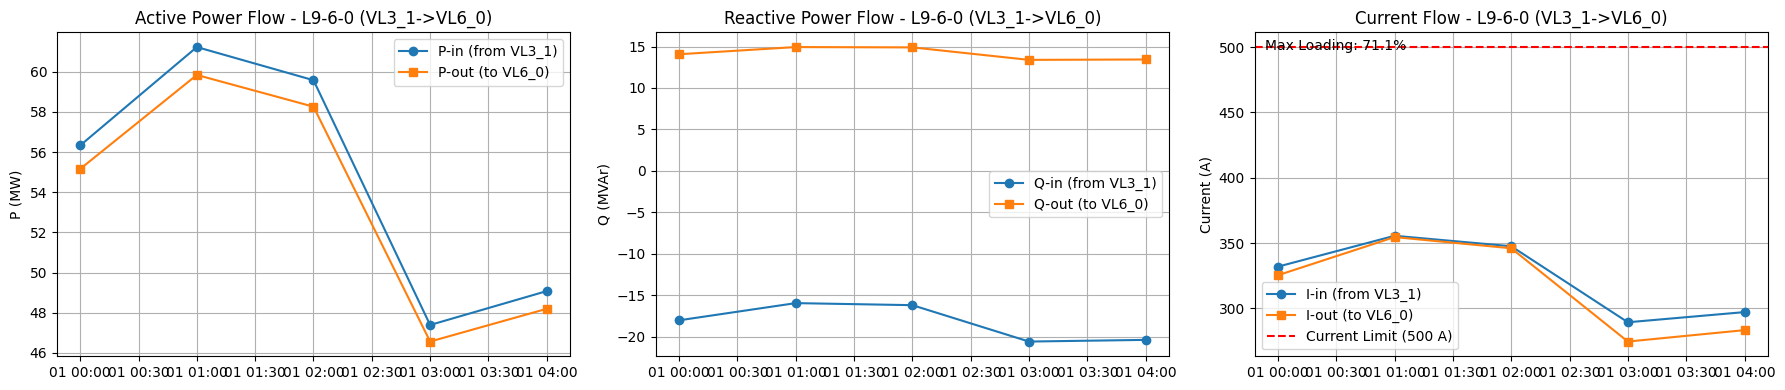

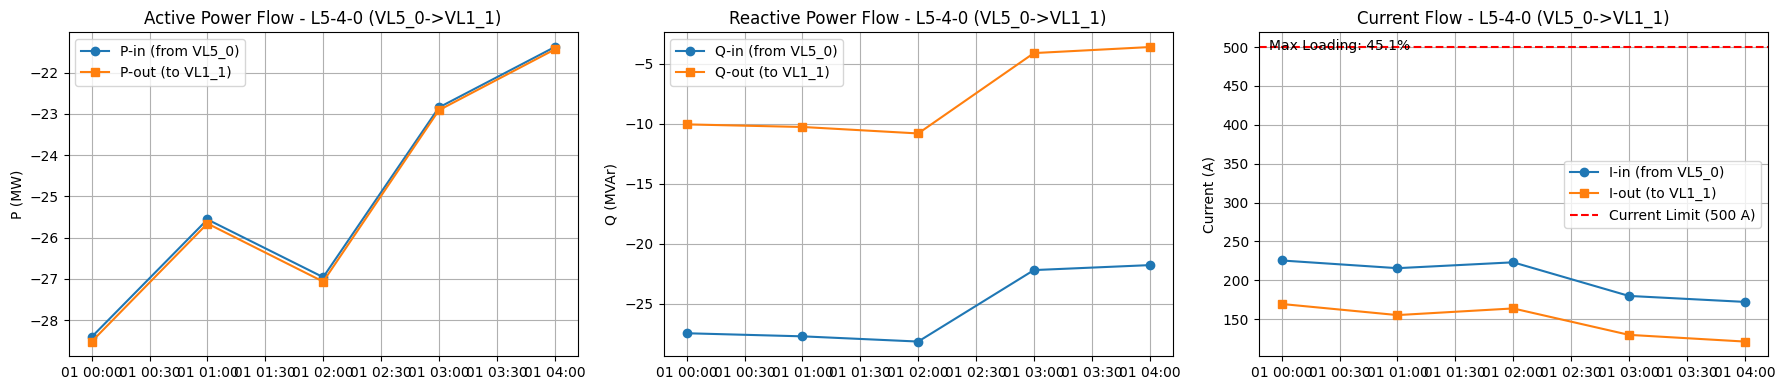

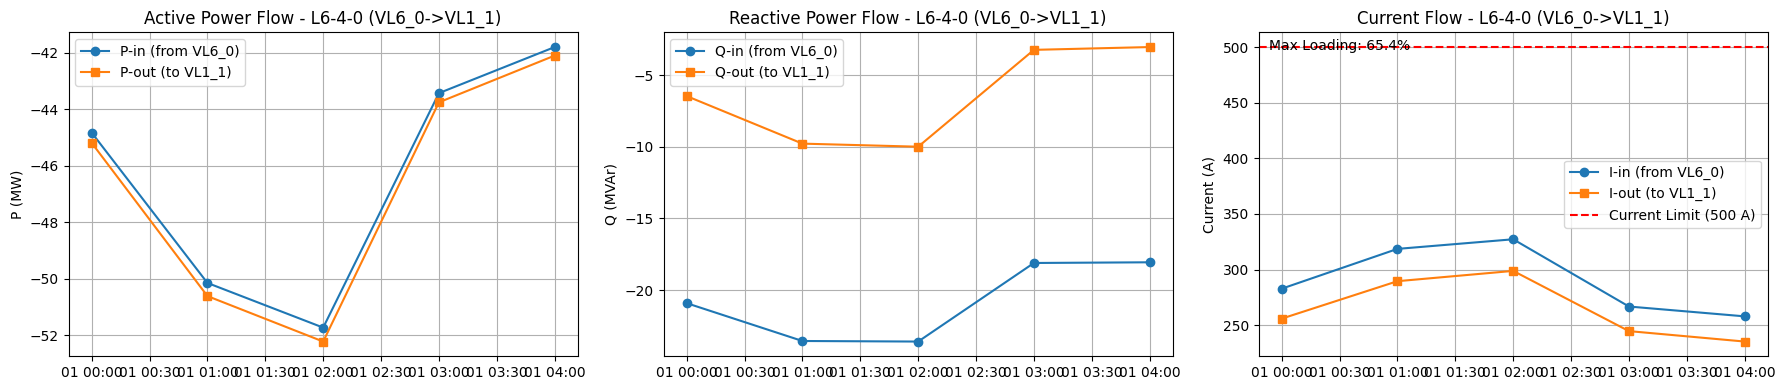

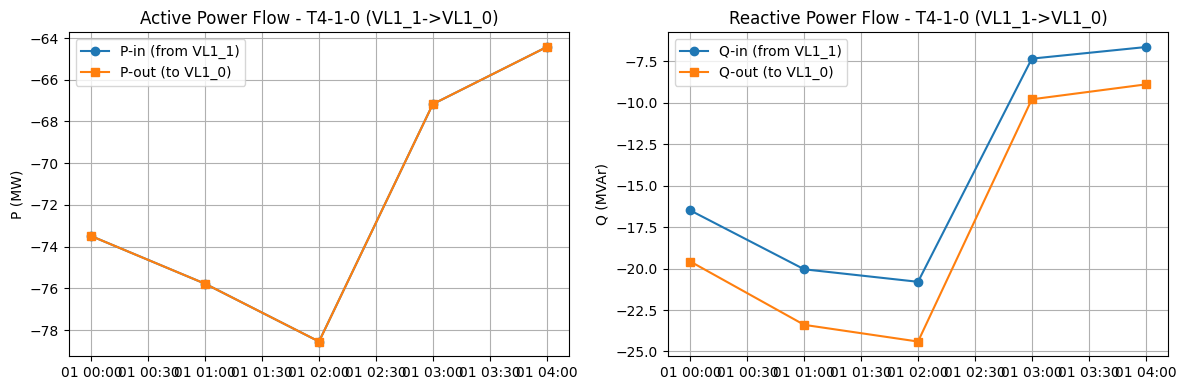

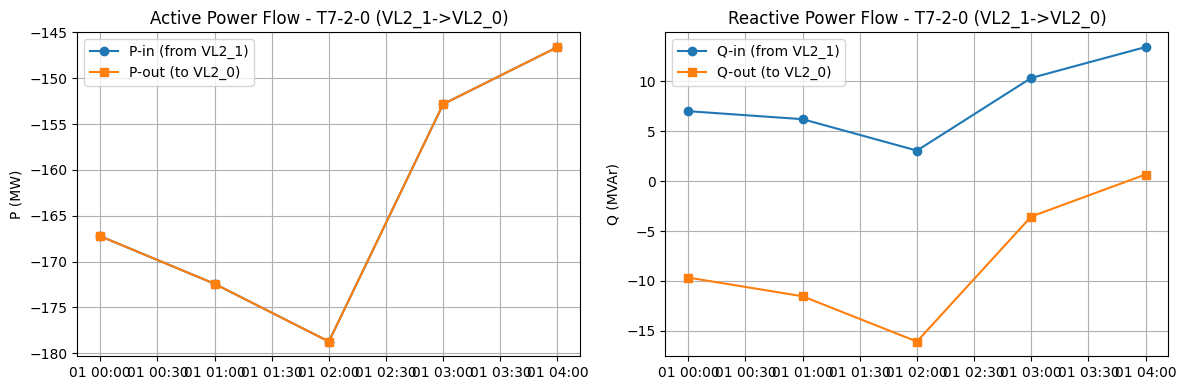

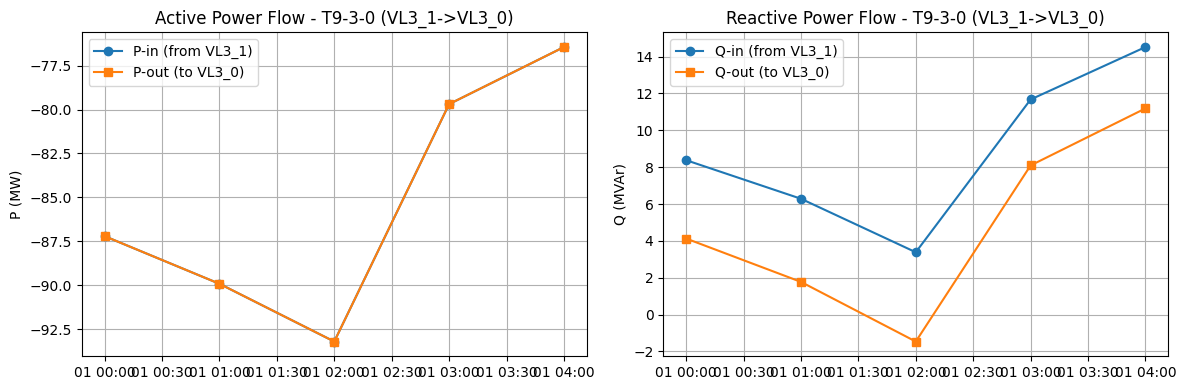

In [8]:
line_limits = {
    'L7-8-0': 500,  # 500 A permanent limit
    'L9-8-0': 500,
    'L7-5-0': 500,
    'L9-6-0': 500,
    'L5-4-0': 500,
    'L6-4-0': 500
}
# Run with distributed slack and line limits
results_l = run_power_system_analysis(
    steps=5,
    use_configured_slack=True,
    balance_method='P',
    line_limits=line_limits,
    #save_results=True,# if you want to save as csv
)